<a href="https://colab.research.google.com/github/matdcp/Data-dreamers-/blob/main/DEAofficial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

# Carica i file manualmente
uploaded = files.upload()  # Seleziona i file file1.ann e file2.ann dalla tua scrivania

Saving file2.ann to file2.ann
Saving file1.ann to file1.ann


In [2]:
import csv
import pandas as pd

# Funzione per convertire un file .ann in .csv
def convert_ann_to_csv(input_file, output_file):
    data = []
    with open(input_file, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()  # Rimuovi spazi vuoti
            if line and '\t' in line:  # Controlla che non sia vuota e contenga tabulazioni
                parts = line.split('\t')
                if len(parts) == 4:  # Controlla che ci siano esattamente 4 colonne
                    id, start, end, label = parts
                    # Filtra token non alfanumerici o righe non valide
                    if id.isalnum() or len(id) > 1:  # Mantieni token validi
                        try:
                            # Prova a convertire start e end in interi
                            data.append([id, int(start), int(end), label])
                        except ValueError:
                            continue

    # Scrivi il file CSV
    with open(output_file, 'w', encoding='utf-8', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['id', 'Start', 'End', 'Label'])  # Intestazioni
        writer.writerows(data)

# Percorsi dei file .ann
file1_ann_path = 'file1.ann'  # Sostituisci con il percorso reale
file2_ann_path = 'file2.ann'  # Sostituisci con il percorso reale

# Percorsi dei file CSV temporanei
file1_csv_path = 'file1_converted.csv'
file2_csv_path = 'file2_converted.csv'

# Conversione dei file .ann in .csv
convert_ann_to_csv(file1_ann_path, file1_csv_path)
convert_ann_to_csv(file2_ann_path, file2_csv_path)

# Caricamento dei file CSV convertiti in DataFrame
df1 = pd.read_csv(file1_csv_path)
df2 = pd.read_csv(file2_csv_path)

# Unione dei DataFrame
ds = pd.concat([df1, df2], ignore_index=True)

# Salvataggio del dataset unito come CSV
merged_dataset_path = 'merged_dataset.csv'
ds.to_csv(merged_dataset_path, index=False)

# Visualizzazione del risultato
print(f"Dataset unito salvato come '{merged_dataset_path}'")
print(ds.head())



Dataset unito salvato come 'merged_dataset.csv'
             id  Start  End                     Label
0   Ventricular      0   11  B-Multi-tissue_structure
1  fibrillation     12   24                         O
2           due     25   28                         O
3            to     29   31                         O
4          long     32   36                         O


In [ ]:
!pip install pandas matplotlib

In [3]:

import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
import spacy
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.interpolate import make_interp_spline
from collections import Counter
from scipy.interpolate import make_interp_spline

# DATA EXPLORATORY ANALYSIS (DEA)

# MISSING VALUES

Handling missing values is a critical step in any data preprocessing pipeline, as they can introduce bias or reduce the performance of subsequent analyses and models.

In [4]:
ds.isnull().sum()

,0
id,18
Start,0
End,0
Label,0


The dataset contains 18 missing values, which could negatively impact subsequent analyses and operations. To address this issue, we will simply remove these missing entries using the pandas dropna() function. This approach ensures a cleaner and more reliable dataset for further processing.

In [5]:
ds.dropna(inplace=True)

# Classification labels frequency



As the first step of the exploratory analysis, we printed all the named entity recognition (NER) tags along with their frequencies in the biomedical papers under analysis.

In [6]:
ds['Label'].unique()

array(['B-Multi-tissue_structure', 'O', 'B-Organism_substance',
       'B-Organism_subdivision', 'B-Organ', 'I-Multi-tissue_structure',
       'B-Cellular_component', 'I-Cellular_component', 'B-Cell', 'I-Cell',
       'B-Immaterial_anatomical_entity', 'B-Tissue', 'I-Tissue',
       'B-Pathological_formation', 'B-Anatomical_system',
       'I-Organism_substance', 'I-Anatomical_system',
       'I-Pathological_formation', 'I-Immaterial_anatomical_entity',
       'I-Organ', 'I-Organism_subdivision',
       'B-Developing_anatomical_structure',
       'I-Developing_anatomical_structure'], dtype=object)

In [7]:

ds['Label'].value_counts()

,count
Label,
O,91805
B-Cell,776
B-Multi-tissue_structure,639
I-Cell,442
B-Organ,381
B-Pathological_formation,367
I-Multi-tissue_structure,359
B-Organism_substance,291
I-Pathological_formation,230


In [8]:
count_O = ds['Label'].value_counts().get('O',0)
print(count_O)
O_frequency = (count_O / len(ds)) *100
print(O_frequency)

91805
95.28875695424728


In the following, we performed a mapping of the NER tags by grouping the labels of the same class, marked with either I or B, into a single representative label for each class. This was done to provide a clearer representation of the frequency with which each class appears in the text.
Hence, We represented the token distribution per class using histograms, both before and after applying the mapping.

For the purpose of creating an explanatory graphical representation of the frequency, I excluded the Outside (O) NER tags from the mapping. This decision was made because, as observed in the output of the counts, there is a clear and significant imbalance, with O accounting for 91805 occurrences, representing 95% of the total NER tags.

In [9]:
# mapping lables

mapping = {'B-Multi-tissue_structure': 'Multi-tissue_structure',
           'I-Multi-tissue_structure': 'Multi-tissue_structure',
           'B-Organism_substance':'Organism_substance',
           'I-Organism_substance':'Organism_substance',
           'B-Organism_subdivision':'Organism_subdivision',
           'I-Organism_subdivision':'Organism_subdivision',
           'B-Organ':'Organ',
           'I-Organ':'Organ',
           'B-Cellular_component':'Cellular_component',
           'I-Cellular_component':'Cellular_component',
           'B-Cell':'Cell',
           'I-Cell':'Cell',
           'B-Immaterial_anatomical_entity':'Immaterial_anatomical_entity',
           'I-Immaterial_anatomical_entity':'Immaterial_anatomical_entity',
           'B-Tissue':'Tissue',
           'I-Tissue':'Tissue',
           'B-Pathological_formation':'Pathological_formation',
           'I-Pathological_formation':'Pathological_formation',
           'B-Anatomical_system':'Anatomical_system',
           'I-Anatomical_system':'Anatomical_system',
           'B-Developing_anatomical_structure':'Developing_anatomical_structure',
           'I-Developing_anatomical_structure':'Developing_anatomical_structure',
           'O': 'O'

}

In [10]:
mapped_ds = ds.copy()
ds1 = ds.copy()
mapped_ds['Label'] = mapped_ds['Label'].map(mapping)
mapped_ds_without_O= mapped_ds[mapped_ds['Label'] != 'O']
ds_without_O = ds1[ds1['Label'] != 'O']

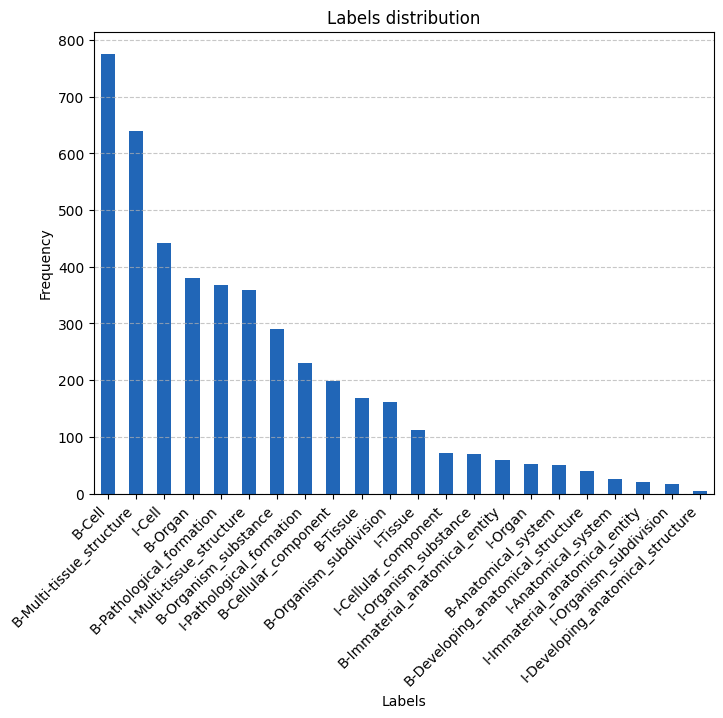

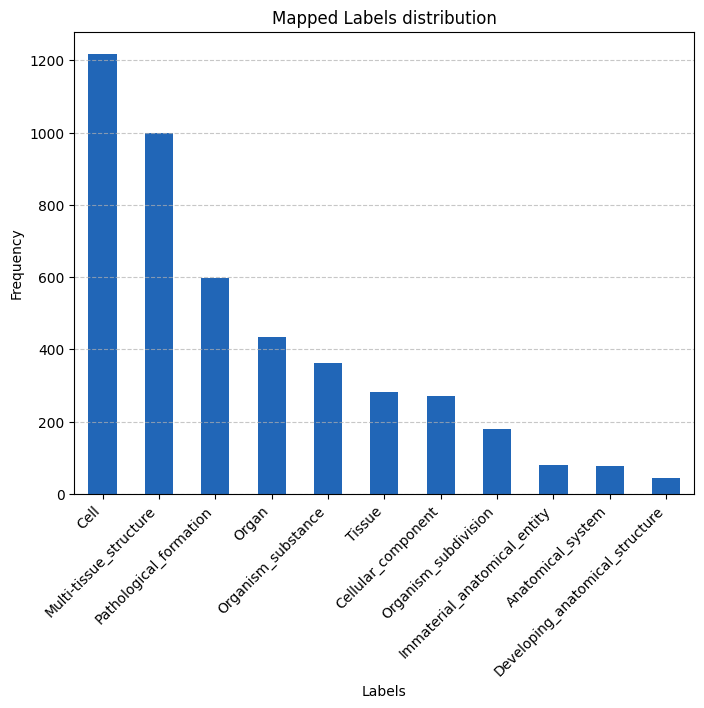

In [11]:
label_counts_mapped = mapped_ds_without_O['Label'].value_counts()
label_counts = ds_without_O['Label'].value_counts()

plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color='#2166b7')
plt.title('Labels distribution')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Ruota le etichette per leggibilità
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(8, 6))
label_counts_mapped.plot(kind='bar', color='#2166b7')
plt.title('Mapped Labels distribution')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Ruota le etichette per leggibilità
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Based on the histograms, before the mapping, the dataset exhibits a higher granularity with distinct "B-" and "I-" prefix labels representing token positions in entities. After the mapping, the labels are consolidated into broader categories, reducing the overall complexity and improving the class balance. This transformation helps simplify the classification task while retaining the essential distinctions needed for entity extraction.

# MOST FREQUENT TOKENS

Using the RegexpTokenizer(r'\w+') from NLTK, which employs the regular expression \w+ to extract alphanumeric sequences, we removed delimiters such as punctuation and other undesired symbols. This step was taken to focus the subsequent analysis on identifying semantic patterns and examining token frequency by class.

Following this, we leveraged spaCy to remove default stop words provided by the library. Since stop words often dominate token frequency counts, their removal aligns with the rationale behind eliminating delimiters: to ensure that the analysis emphasizes meaningful and semantically relevant tokens.

In [12]:
#delimiters
tokenizer = RegexpTokenizer(r'\w+')
ds['id'] = ds['id'].apply(lambda x: ' '.join(tokenizer.tokenize(str(x))))

In [13]:
#stopwords
nlp = spacy.load("en_core_web_sm")
print(nlp.Defaults.stop_words)

{'fifteen', 'whether', 'n’t', 'first', 'per', 'until', 'anyway', 'most', 'behind', 'he', 'none', '‘ve', 'herself', 'through', 'mine', 'mostly', 'between', 'she', 'thereupon', 'wherever', 'being', 'even', 'hereby', 'another', 'whom', 'make', 'among', 'nor', 'yours', 'four', "'m", 'becomes', 'with', 'myself', 'to', 'its', 'that', "'ve", '’ve', 'have', 'on', 'sixty', 'seeming', 'onto', 'two', 'something', 'if', 'everywhere', 'six', 'someone', 'us', 'next', 'show', 'yet', 'bottom', 'quite', 'namely', 'off', 'n‘t', 'against', 'meanwhile', 'were', 'third', 'beside', 'serious', 'seems', 'across', 'may', 'because', 'about', 'call', 'every', 'had', 'empty', 'somewhere', 'the', 'rather', 'what', 'him', 'everyone', 'nothing', 'when', 'hence', 'your', 'three', 'why', 'made', 'thereby', 'upon', 'are', 'been', 'never', 'as', 'toward', 'such', 'somehow', 'become', 'take', 'eleven', 'there', 'than', 'all', 'anywhere', 'throughout', 'few', 'by', 'everything', 'full', 'those', 'although', 'whoever', 'th

In [14]:
def remove_stop_words(text):
    doc = nlp(text)
    return ' '.join([token.text for token in doc if not token.is_stop])

ds['id'] = ds['id'].apply(remove_stop_words)

In [15]:
most_common_tokens = ds['id'].value_counts().head(10)
print(most_common_tokens)

id
            35287
1             551
0             499
5             404
2             400
patients      323
3             301
cells         236
4             236
6             195
Name: count, dtype: int64


Following, we represented the most frequent tokens for each label individually. This step helps to identify distinctive terms associated with specific labels, providing insights into the linguistic patterns that could be useful for model training and improving classification performance.

In [16]:

# Conta i token più frequenti per ciascuna classe
most_common_tokens_per_class = (
    ds.groupby('Label')['id']
    .value_counts()  # Conta i token per classe
    .groupby(level=0)  # Raggruppa di nuovo per classe
    .head(5)  # Prendi i primi 5 token per classe
)

# Trasforma in DataFrame con tutte le informazioni necessarie
most_common_tokens = most_common_tokens_per_class.reset_index(name='Frequency')

# Verifica che il risultato sia un DataFrame
print(type(most_common_tokens))  # Dovrebbe essere <class 'pandas.core.frame.DataFrame'>
print(most_common_tokens.head())  # Verifica la struttura


<class 'pandas.core.frame.DataFrame'>
                 Label             id  Frequency
0  B-Anatomical_system    respiratory          9
1  B-Anatomical_system  corticospinal          7
2  B-Anatomical_system   neurological          7
3  B-Anatomical_system        central          5
4  B-Anatomical_system       skeletal          5


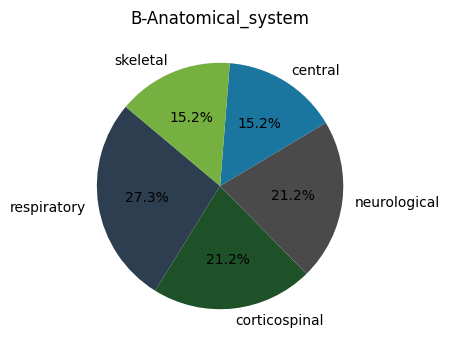

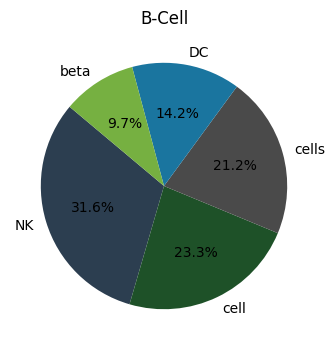

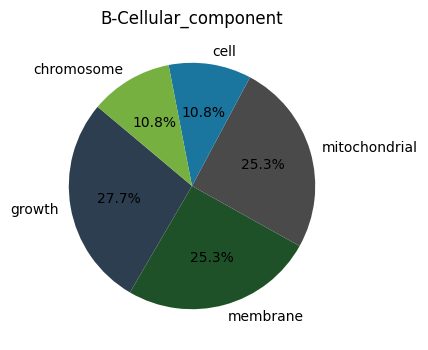

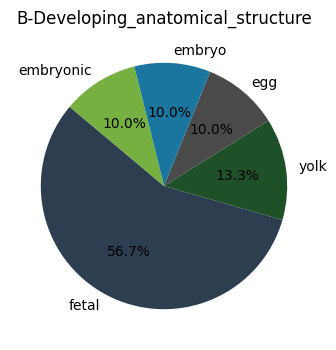

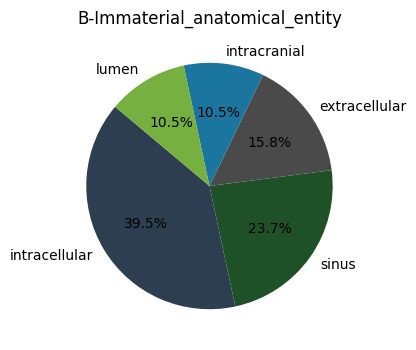

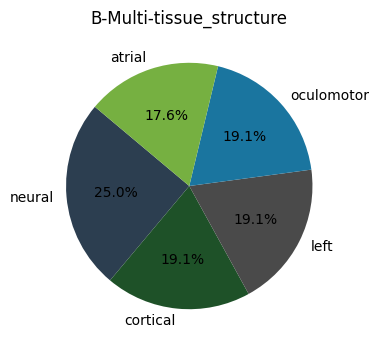

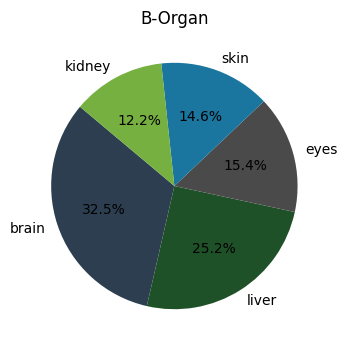

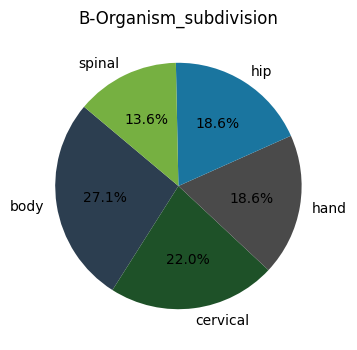

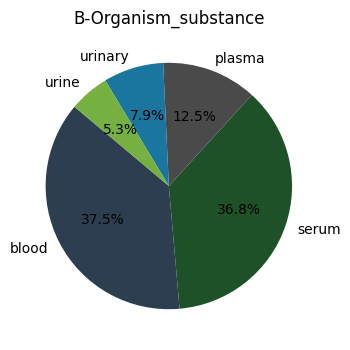

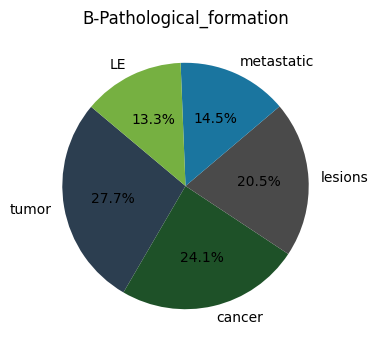

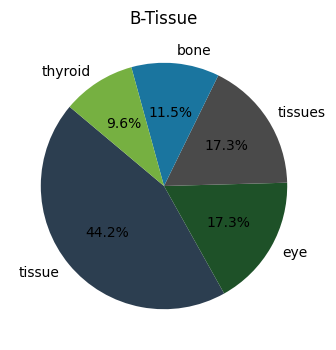

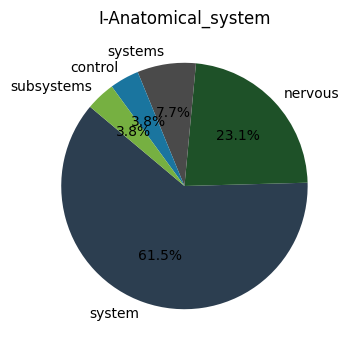

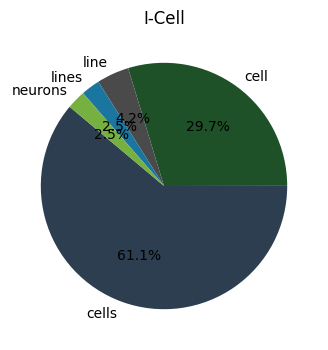

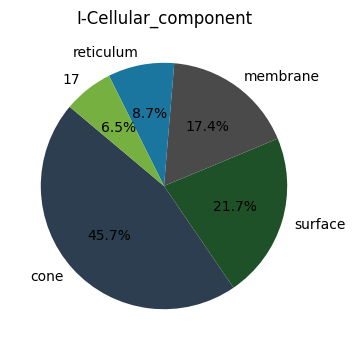

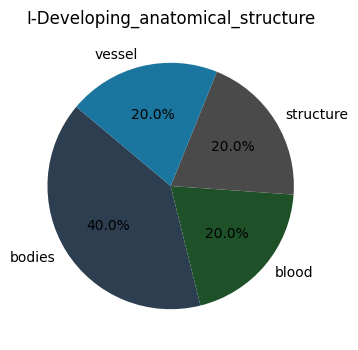

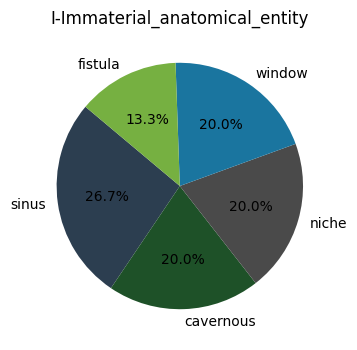

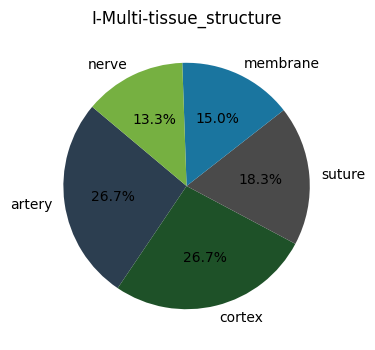

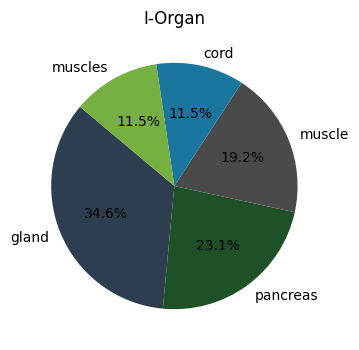

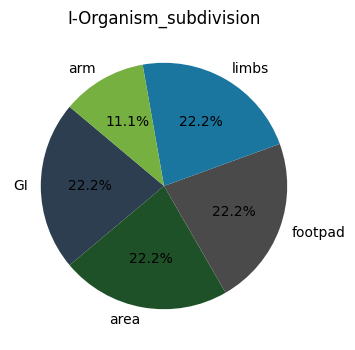

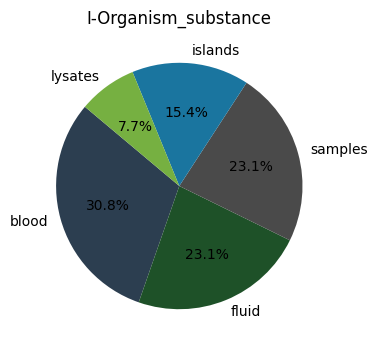

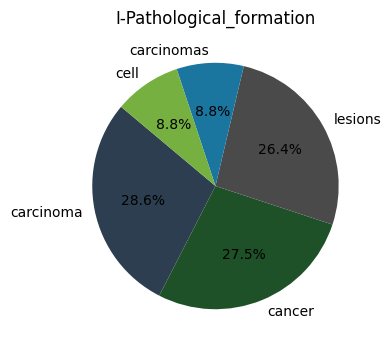

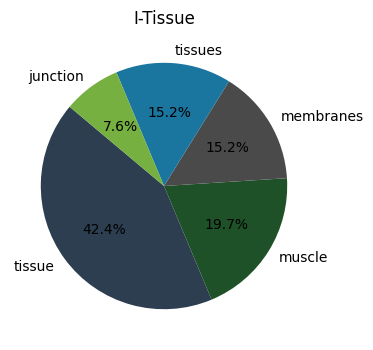

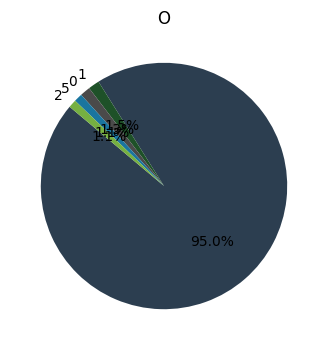

In [17]:
import matplotlib.pyplot as plt


for label in most_common_tokens['Label'].unique():
    class_tokens = most_common_tokens[most_common_tokens['Label'] == label]
    plt.figure(figsize=(4, 4))
    plt.pie(
        class_tokens['Frequency'],
        labels=class_tokens['id'],
        autopct='%1.1f%%',
        startangle=140,
        colors = ['#2C3E50', '#1E5128', '#4A4A4A', '#1A759F', '#76B041',
                          '#3C3C3C', '#1F4E5F', '#9DA5B0', '#2B9348', '#5C5C5C']
    )
    plt.title(label)
    plt.show()




Ecco una lista ordinata di step per completare la tua Data Exploratory Analysis (DEA):

1. Analisi delle distribuzioni statistiche
Calcola e rappresenta graficamente:
La distribuzione della lunghezza delle frasi.
La distribuzione della lunghezza dei token.


2. Analisi linguistica del corpus
POS tagging: Analizza e visualizza la distribuzione delle Part-of-Speech (POS) nei dati per comprendere la struttura linguistica delle frasi.
Dependency parsing: Studia le relazioni grammaticali tra i token (es. soggetto-verbo-oggetto) e verifica se alcune strutture sintattiche sono associate a determinate classi.
Analisi dei lemmi: Analizza i lemmi più frequenti per verificare se ci sono variazioni significative rispetto ai token.
3. Word Cloud per le classi
Crea una Word Cloud per ogni classe per visualizzare rapidamente i termini più rappresentativi (già hai analizzato i token frequenti, ma la Word Cloud aggiunge una componente visiva utile).
4. Analisi delle n-gram
Studia i bigrammi e i trigrammi più frequenti per ogni classe e rappresentali graficamente. Questo può aiutarti a cogliere combinazioni di parole specifiche per ogni entità.
5. Riduzione dimensionale del testo
Utilizza LDA (Latent Dirichlet Allocation) o NMF (Non-negative Matrix Factorization) per analizzare i temi latenti nel corpus e vedere se corrispondono a pattern di classificazione già noti.
Rappresenta graficamente i temi latenti con t-SNE o UMAP per una migliore visualizzazione.

6. Report finale DEA. fare una dashbord
Organizza i risultati in un report visivo e descrittivo, includendo:
Grafici di distribuzione e tabelle riassuntive.
Le principali intuizioni derivate da ciascun passo.
Considerazioni sui pattern osservati e il loro impatto sull’implementazione dei modelli successivi.


DISTRIBUZIONE DELLA LUNGHEZZA DEI TOKEN

In [18]:

import seaborn as sns

ds['token_length'] = ds['id'].apply(len)
token_stats = ds.groupby('Label')['token_length'].agg(['mean', 'median', 'std', 'min', 'max', ]).reset_index()
print(token_stats)


                                Label       mean  median       std  min  max
0                 B-Anatomical_system  10.000000    11.0  3.000000    3   15
1                              B-Cell   5.226804     4.0  3.181414    0   16
2                B-Cellular_component   8.713568     8.0  3.090122    1   15
3   B-Developing_anatomical_structure   5.615385     5.0  2.059834    3   14
4      B-Immaterial_anatomical_entity   9.450000    11.5  4.106320    4   17
5            B-Multi-tissue_structure   7.248826     7.0  2.591110    2   18
6                             B-Organ   5.776903     5.0  1.820957    2   12
7              B-Organism_subdivision   5.567901     5.0  2.589699    0   16
8                B-Organism_substance   5.790378     5.0  2.069660    0   14
9            B-Pathological_formation   7.092643     6.0  3.391105    2   19
10                           B-Tissue   7.130178     7.0  2.669421    2   15
11                I-Anatomical_system   6.500000     6.0  0.860233    6   10

<Figure size 1200x800 with 0 Axes>

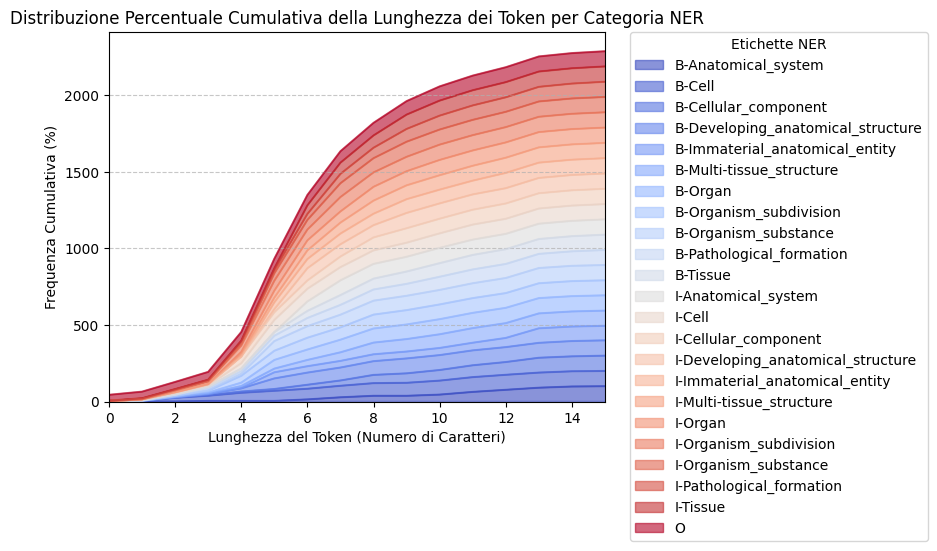

In [19]:

# Calcolo della distribuzione delle lunghezze dei token per ciascuna categoria NER
token_length_distribution = ds.groupby(['token_length', 'Label']).size().unstack(fill_value=0)

# Calcolo della distribuzione cumulativa per ogni categoria in percentuale
token_length_distribution_cumsum = token_length_distribution.cumsum()
token_length_distribution_percent = (token_length_distribution_cumsum / token_length_distribution_cumsum.max()) * 100

# Creazione del grafico ad area per rappresentare la distribuzione cumulativa
plt.figure(figsize=(12, 8))
token_length_distribution_percent.plot(kind='area', stacked=True, alpha=0.6, colormap="coolwarm")

plt.title("Distribuzione Percentuale Cumulativa della Lunghezza dei Token per Categoria NER")
plt.xlabel("Lunghezza del Token (Numero di Caratteri)")
plt.ylabel("Frequenza Cumulativa (%)")
plt.legend(title="Etichette NER",  bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.) #bbox per spostare la legenda a sinistra
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(0, 15)  # Limitiamo a 15 caratteri per visualizzare la maggior parte dei token

plt.show()


DISTRIBUZIONE LUNGHEZZA FRASI

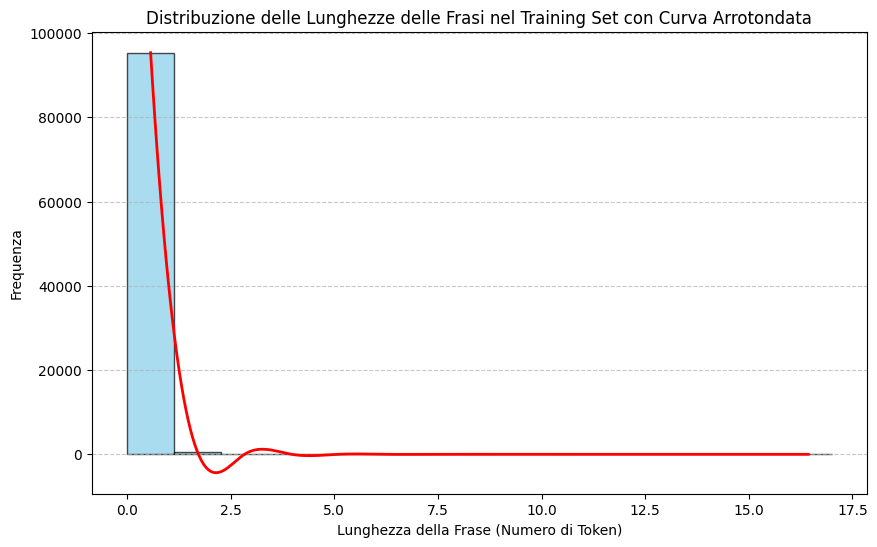

In [22]:



ds['Sentence_ID'] = (ds['Start'] > ds['End'].shift(fill_value=0)).cumsum()

# Conta il numero di token per ciascuna frase
sentence_lengths = ds.groupby('Sentence_ID').size()

# Creazione dell'istogramma
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=15, range=(0, 17), color='skyblue', edgecolor='black', alpha=0.7)

# curva smussata
bin_counts, bin_edges = np.histogram(sentence_lengths, bins=15, range=(0, 17))
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
xnew = np.linspace(bin_centers.min(), bin_centers.max(), 300)
spline = make_interp_spline(bin_centers, bin_counts, k=3)
y_smooth = spline(xnew)

# Aggiunta della curva interpolata
plt.plot(xnew, y_smooth, color='red', linewidth=2)

# Personalizzazione del grafico
plt.title("Distribuzione delle Lunghezze delle Frasi ")
plt.xlabel("Lunghezza della Frase (Numero di Token)")
plt.ylabel("Frequenza")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


POS

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


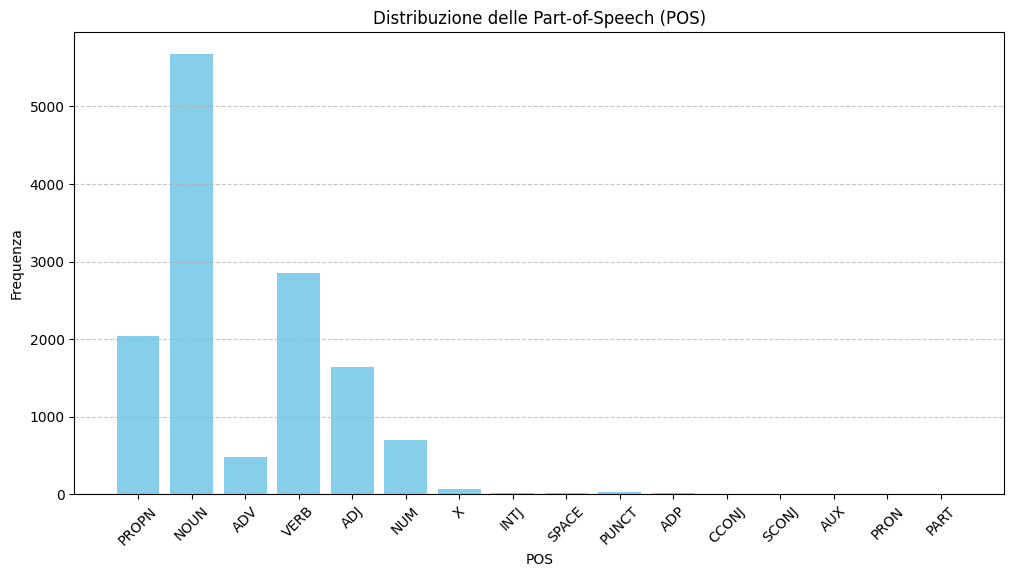

In [23]:

# Carica il modello spaCy
nlp = spacy.load('en_core_web_sm')

# Esegui il POS tagging sul dataset
def pos_tagging(text):
    doc = nlp(text)
    return [token.pos_ for token in doc]


# Unisci i token per creare frasi
if 'Sentence_ID' in ds.columns:
    ds['sentence'] = ds.groupby('Sentence_ID')['id'].transform(lambda x: ' '.join(x))

# Rimuovi duplicati e tieni solo le frasi uniche
unique_sentences = ds[['sentence']].drop_duplicates().dropna()

# Applica il POS tagging a ciascuna frase
unique_sentences['POS'] = unique_sentences['sentence'].apply(pos_tagging)

# Conteggia le occorrenze delle POS
pos_counts = Counter([pos for pos_list in unique_sentences['POS'] for pos in pos_list])


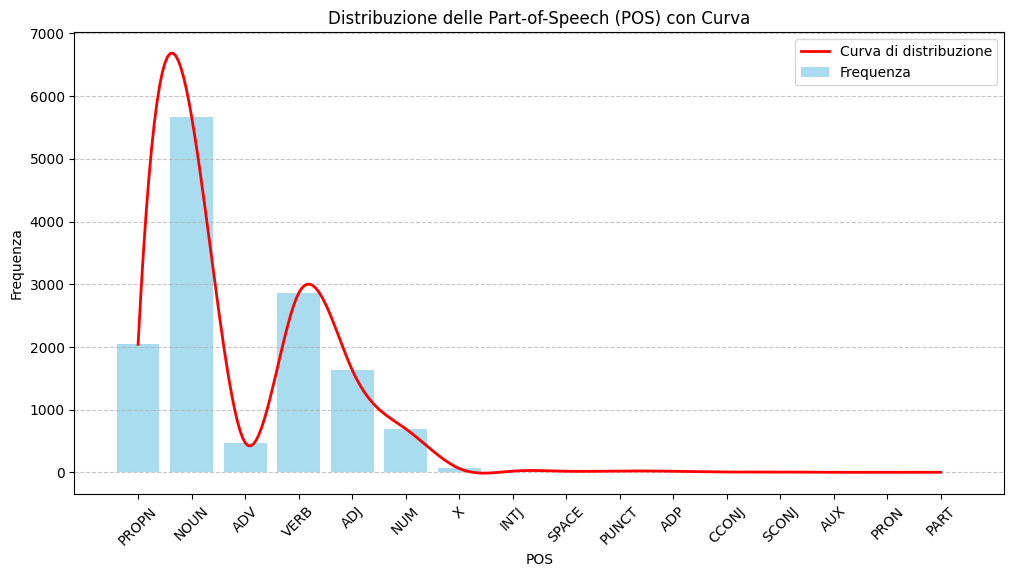

In [27]:


from scipy.interpolate import make_interp_spline


plt.figure(figsize=(12, 6))

# Grafico a barre
plt.bar(pos_counts.keys(), pos_counts.values(), color='skyblue', alpha=0.7, label="Frequenza")

# Interpolazione spline per la curva
x_pos = np.arange(len(pos_counts.keys()))  # Posizioni delle POS sull'asse X
y_pos = np.array(list(pos_counts.values()))  # Frequenze delle POS
x_smooth = np.linspace(x_pos.min(), x_pos.max(), 300)
spline = make_interp_spline(x_pos, y_pos, k=3)  # Interpolazione spline
y_smooth = spline(x_smooth)

# Aggiunta della curva interpolata
plt.plot(x_smooth, y_smooth, color='red', linewidth=2, label="Curva di distribuzione")

# Personalizzazione del grafico
plt.title("Distribuzione delle Part-of-Speech (POS) con Curva")
plt.xlabel("POS")
plt.ylabel("Frequenza")
plt.xticks(ticks=x_pos, labels=pos_counts.keys(), rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.show()